### Import Lib

In [2]:
import re
import numpy as np 

In [3]:
data_example = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."

### Data preprocessing 

##### Token -> tách các từ thành từng token( có thể trùng nhau )

In [4]:
def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [7]:
tokens = tokenize(data_example)
tokens

['after',
 'the',
 'deduction',
 'of',
 'the',
 'costs',
 'of',
 'investing',
 'beating',
 'the',
 'stock',
 'market',
 'is',
 'a',
 "loser's",
 'game']

##### Tạo mapping từ word2id và id2word

In [8]:
def mapping(tokens):
    word2id = dict() 
    id2word = dict() 

    for i, token in enumerate(set(tokens)):
        word2id[token] = i 
        id2word[i] = token 
    return word2id,id2word 
    

In [9]:
word2id, id2word = mapping(tokens)

In [10]:
print("Word2Id:  ",word2id)
print("Id2word: ",id2word)

Word2Id:   {'market': 0, 'is': 1, 'of': 2, 'investing': 3, 'the': 4, 'stock': 5, 'beating': 6, 'game': 7, "loser's": 8, 'a': 9, 'after': 10, 'costs': 11, 'deduction': 12}
Id2word:  {0: 'market', 1: 'is', 2: 'of', 3: 'investing', 4: 'the', 5: 'stock', 6: 'beating', 7: 'game', 8: "loser's", 9: 'a', 10: 'after', 11: 'costs', 12: 'deduction'}


##### Tạo bộ dữ liệu --> Với skip-gram thì các từ trung tâm sẽ dùng để dự đoán các từ context 
$X = w_t$

$Y = \{w_{t-n},w_{t-n+1},...w_{t-1},w_{t+1},...w_{t+n}\}$

In [6]:
def generate_training_data(tokens, word_to_ids, window_size):
    N = len(tokens) 
    X, Y = [], [] 

    for i in range(N):
        window_word = list(range(max(0,i - window_size),i)) + list(range(i+1,min(i+ window_size + 1 , N))) 
        for j in window_word: 
            X.append(word_to_ids[tokens[i]]) 
            Y.append(word_to_ids[tokens[j]]) 
    X = np.array(X) 
    Y = np.array(Y) 
    X = np.expand_dims(X, axis = 0 )
    Y = np.expand_dims(Y, axis = 0) 
    return X,Y 

In [11]:
X,Y = generate_training_data(tokens, word2id, window_size = 3)
print("X: ",X)
print("Y: ",Y)

X:  [[10 10 10  4  4  4  4 12 12 12 12 12  2  2  2  2  2  2  4  4  4  4  4  4
  11 11 11 11 11 11  2  2  2  2  2  2  3  3  3  3  3  3  6  6  6  6  6  6
   4  4  4  4  4  4  5  5  5  5  5  5  0  0  0  0  0  0  1  1  1  1  1  1
   9  9  9  9  9  8  8  8  8  7  7  7]]
Y:  [[ 4 12  2 10 12  2  4 10  4  2  4 11 10  4 12  4 11  2  4 12  2 11  2  3
  12  2  4  2  3  6  2  4 11  3  6  4  4 11  2  6  4  5 11  2  3  4  5  0
   2  3  6  5  0  1  3  6  4  0  1  9  6  4  5  1  9  8  4  5  0  9  8  7
   5  0  1  8  7  0  1  9  7  1  9  8]]


In [14]:
X = np.array(X) 
Y = np.array(Y)

In [19]:
X_word = [id2word[i] for i in X[0]]
print("X: ",X_word)
Y_word = [id2word[i] for i in Y[0]]
print("Y: ",Y_word)

X:  ['after', 'after', 'after', 'the', 'the', 'the', 'the', 'deduction', 'deduction', 'deduction', 'deduction', 'deduction', 'of', 'of', 'of', 'of', 'of', 'of', 'the', 'the', 'the', 'the', 'the', 'the', 'costs', 'costs', 'costs', 'costs', 'costs', 'costs', 'of', 'of', 'of', 'of', 'of', 'of', 'investing', 'investing', 'investing', 'investing', 'investing', 'investing', 'beating', 'beating', 'beating', 'beating', 'beating', 'beating', 'the', 'the', 'the', 'the', 'the', 'the', 'stock', 'stock', 'stock', 'stock', 'stock', 'stock', 'market', 'market', 'market', 'market', 'market', 'market', 'is', 'is', 'is', 'is', 'is', 'is', 'a', 'a', 'a', 'a', 'a', "loser's", "loser's", "loser's", "loser's", 'game', 'game', 'game']
Y:  ['the', 'deduction', 'of', 'after', 'deduction', 'of', 'the', 'after', 'the', 'of', 'the', 'costs', 'after', 'the', 'deduction', 'the', 'costs', 'of', 'the', 'deduction', 'of', 'costs', 'of', 'investing', 'deduction', 'of', 'the', 'of', 'investing', 'beating', 'of', 'the', 

###  Model 

In [153]:
def softmax(x):
    return np.divide(np.exp(x),(np.sum(np.exp(x),axis = 0, keepdims=True) + 0.001))

In [220]:
class Training():
    def __init__(self,vocab_size):
        self.vocab_size = vocab_size 
    def init(self,embed_dim,output_dim):
        word_vec  = np.random.randn(self.vocab_size,embed_dim) * 0.01  
        w = np.random.randn(output_dim,embed_dim) * 0.01 
        self.parameter = { }
        self.parameter['word_vec'] = word_vec
        self.parameter['w'] = w 
        # return parameter 
    def forward(self,x):
        word_vec = self.parameter['word_vec'][x,:].T ### Chuyển từ id -> word_vec (emb,B)
        n = word_vec.shape[1] 
        w = self.parameter['w']     ## out, emb
        z = np.dot(w,word_vec) 
        self.out = softmax(z) 
        self.cache = {} 
        self.cache['inds'] = x 
        self.cache['word_vec'] = word_vec 
        self.cache['w'] = w 
        self.cache['z'] = z 
    def loss(self,y):
        m = self.out.shape[1] 
        loss = -(1/m) * np.sum(np.sum(y * np.log(self.out + 0.001), axis = 0 , keepdims= True) , axis = 1)
        return loss 
    def backward(self,y):
        w = self.cache['w']
        x = self.cache['word_vec']
        m = x.shape[1]

        dz = self.out - y 
        dx = np.dot(w.T,dz)
        dw = (1/m) * np.dot(dz,x.T)

        self.gradient = dict()
        self.gradient['dz'] = dz 
        self.gradient['dw'] = dw 
        self.gradient['dx'] = dx

    def update(self,lr):
        id = self.cache['inds'] 
        dx = self.gradient['dx']
        dw = self.gradient['dw']
        x = self.cache['inds']
        
        self.parameter['word_vec'][x,:] -= lr * dx.T 
        self.parameter['w'] -= lr * dw 
        

### Training 

In [224]:
def skipgram(X,Y,vocab_size, emb_dim,output_dim, lr, epochs, batch_size, print_loss):
    loss_ = [] 
    m = X.shape[0] 
    train = Training(vocab_size)
    train.init(emb_dim,output_dim)
    start_time = time.time() 
    for epoch in range(epochs):
        epoch_loss =  0 
        batch_data = list(range(0,m,batch_size))
        np.random.shuffle(batch_data)
        for i in batch_data:
            X_batch = X[i:i+batch_size]
            Y_batch = Y[:,i:i+batch_size] 
            train.forward(X_batch) 
            train.backward(Y_batch) 
            train.update(lr) 
            loss = train.loss(Y_batch)
            epoch_loss += np.squeeze(loss) 
        loss_.append(epoch_loss)
        if print_loss and (epoch % 500 == 0):
            print("Epoch: ",epoch, " -- Loss: ",epoch_loss) 
        if epoch % (epochs // 100) == 0:
            lr *= 0.98 
    end_time = time.time() 
    print("-----------------------")
    print("Training Time: ",end_time - start_time) 

    return train.parameter,loss_


In [225]:
para, loss_ = skipgram(X,Y_one_hot,vocab_size=13,emb_dim=100,output_dim=10,lr = 0.01,epochs = 5000,batch_size= 4,print_loss= True)

ValueError: operands could not be broadcast together with shapes (10,4) (13,4) 

### Evaluate

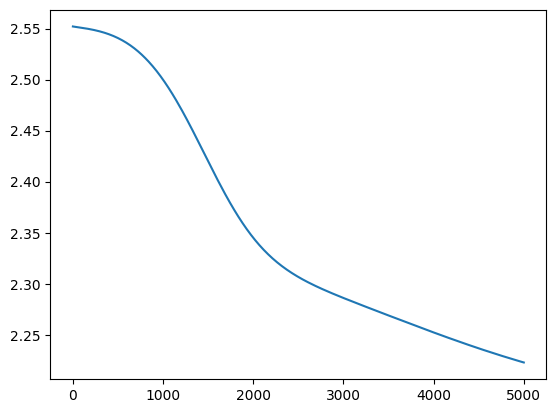

In [205]:
import matplotlib.pyplot as plt 
plt.plot(loss_)

In [208]:
from sklearn.decomposition import PCA


In [209]:
X

array([10, 10, 10,  4,  4,  4,  4, 12, 12, 12, 12, 12,  2,  2,  2,  2,  2,
        2,  4,  4,  4,  4,  4,  4, 11, 11, 11, 11, 11, 11,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,  6,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  9,  9,  9,  9,  9,  8,  8,  8,  8,  7,  7,  7])

In [210]:
word_vec = para['word_vec'][X,:].T ### Chuyển từ id -> word_vec 
w = para['w']
z = np.dot(w,word_vec) 
out = softmax(z)

In [212]:
out.shape

(13, 84)